<a href="https://colab.research.google.com/github/nfpaiva/ml-ai-experiments/blob/main/notebooks/additive-network-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Neural Additive Models (NAM) in PyTorch

This Colab notebook implements **Neural Additive Models (NAMs)** using PyTorch. The architecture and concept are based on the influential paper:

> **"Neural Additive Models: Interpretable Machine Learning with Neural Nets"**  
> Authors: Agarwal et al. (Microsoft Research)  
> 📄 [Read the paper](https://arxiv.org/pdf/2004.13912)

---

## 🎯 Goal

- Reproduce the original TensorFlow-based implementation by Google Research:  
  🔗 https://github.com/google-research/google-research/tree/master/neural_additive_models
- Provide a **fully interpretable neural network model** for structured/tabular data.
- Train and evaluate NAMs on datasets with both **categorical** and **continuous** features.
- Offer a scalable and modern alternative to tree-based Generalized Additive Models (GAMs).

---

## 🚀 Key Highlights

- ✅ Each feature has its own **dedicated neural subnetwork**.
- ✅ Output prediction is the **sum of per-feature contributions** — a classic additive structure.
- ✅ Uses **ExU (Exponential + ReLU-n)** activations for smooth, expressive yet interpretable functions.
- ✅ Designed with **interpretability** as a first-class principle — ideal for regulated and high-stakes domains.

---

## 🌟 Why NAMs Matter — Benefits over Traditional GAMs and DNNs

### 🔬 **Interpretability without Sacrificing Expressiveness**
- Each feature subnetwork can be visualized independently, making NAMs **as interpretable as GAMs**.
- Learned graphs **are the model** — not just post-hoc explanations.

### 🤖 **Deep Learning Native**
- Seamlessly integrates with the deep learning ecosystem (PyTorch, TensorFlow, GPUs/TPUs).
- Can leverage all the tools developed for DNNs: batching, regularization, optimizers, early stopping, etc.
- Easily extensible to **multiclass**, **multi-label**, **multitask**, and even **survival analysis** settings.

### ⚙️ **Composable and Scalable**
- Unlike tree-based GAMs, NAMs are **differentiable** end-to-end, allowing easy integration with other neural modules (e.g., attention, embeddings, multi-head models).
- Trained using **standard backpropagation**, making them ideal for experimentation and production use.

### 📊 **Fewer Components, Better Generalization**
- GAMs may require **millions of decision trees** to approximate smooth shapes.
- NAMs use **compact neural subnetworks (e.g., 2–100)** to achieve similar or better performance with fewer parameters and better generalization.

### 🏥 **Trustworthy AI for High-Stakes Applications**
- Ideal for healthcare, finance, and policy-making where both **predictive power** and **human intelligibility** are essential.
- Already applied in real-world domains like **COVID-19 risk modeling**, **hospital mortality prediction**, and **loan risk scoring**.

---

## 📈 Example Use Case: Credit Risk Prediction

NAMs were applied to the **German Credit dataset** to predict loan approval outcomes:
- See how **age**, **credit amount**, and **employment duration** influence decisions.
- Validate that model behavior aligns with domain expectations and prior studies.
- Reveal insights into which features drive risk perception — **with no black box**.

---


In [135]:
!pip install -q kaggle onnx

In [136]:
import pandas as pd
import numpy as np
import json
import os
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

In [137]:


# If you upload the kaggle.json file manually in the notebook environment
kaggle_token = {
    "username": "your_kaggle_username",
    "key": "your_kaggle_api_key"
}

# Save the token
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(kaggle_token, f)

# Set permissions
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)


### from kaggle go to settings -> create a new token -> download and manually upload kaggle.json to the ~/.kaggle/ folder using the colab file explorer

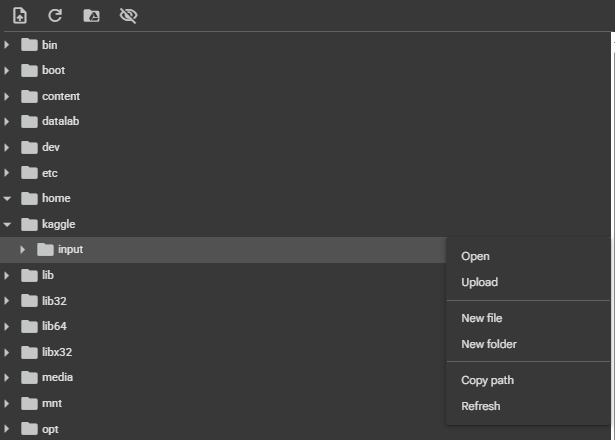

In [138]:
!kaggle datasets download -d varunchawla30/german-credit-data


Dataset URL: https://www.kaggle.com/datasets/varunchawla30/german-credit-data
License(s): DbCL-1.0
german-credit-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [139]:
!unzip -o german-credit-data.zip -d german_credit_data


Archive:  german-credit-data.zip
  inflating: german_credit_data/german_credit_data.csv  


In [151]:
df = pd.read_csv("german_credit_data/german_credit_data.csv")
df.columns

Index(['laufkont', 'laufzeit', 'moral', 'verw', 'hoehe', 'sparkont', 'beszeit',
       'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'alter', 'weitkred',
       'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb', 'kredit'],
      dtype='object')

In [152]:
rename_dict = {
    'laufkont': 'checking_account',
    'laufzeit': 'duration_months',
    'moral': 'credit_history',
    'verw': 'purpose',
    'hoehe': 'credit_amount',
    'sparkont': 'savings_account',
    'beszeit': 'employment_duration',
    'rate': 'installment_rate',
    'famges': 'personal_status',
    'buerge': 'guarantor',
    'wohnzeit': 'residence_duration',
    'verm': 'property',
    'alter': 'age',
    'weitkred': 'other_credit',
    'wohn': 'housing',
    'bishkred': 'number_existing_credits',
    'beruf': 'job',
    'pers': 'dependents',
    'telef': 'telephone',
    'gastarb': 'foreign_worker',
    'kredit': 'target'  #$kredit = credit_risk
                        #0 : bad
                        #1 : good
}

df = df.rename(columns=rename_dict)
df


,checking_account,duration_months,credit_history,purpose,credit_amount,savings_account,employment_duration,installment_rate,personal_status,guarantor,...,property,age,other_credit,housing,number_existing_credits,job,dependents,telephone,foreign_worker,target
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,24,2,3,1987,1,3,2,3,1,...,1,21,3,1,1,2,1,1,2,0
996,1,24,2,0,2303,1,5,4,3,2,...,1,45,3,2,1,3,2,1,2,0
997,4,21,4,0,12680,5,5,4,3,1,...,4,30,3,3,1,4,2,2,2,0
998,2,12,2,3,6468,5,1,2,3,1,...,4,52,3,2,1,4,2,2,2,0


In [155]:
summary = df.describe(include='all').transpose()
summary["unique_vals"] = df.nunique()
summary["dtype"] = df.dtypes
summary["missing_vals"] = df.isna().sum()
summary = summary.sort_values("unique_vals", ascending=True)
summary


,count,mean,std,min,25%,50%,75%,max,unique_vals,dtype,missing_vals
target,1000.0,0.700,0.458487,0.0,0.0,1.0,1.00,1.0,2,int64,0
foreign_worker,1000.0,1.963,0.188856,1.0,2.0,2.0,2.00,2.0,2,int64,0
telephone,1000.0,1.404,0.490943,1.0,1.0,1.0,2.00,2.0,2,int64,0
dependents,1000.0,1.845,0.362086,1.0,2.0,2.0,2.00,2.0,2,int64,0
other_credit,1000.0,2.675,0.705601,1.0,3.0,3.0,3.00,3.0,3,int64,0
housing,1000.0,1.928,0.530186,1.0,2.0,2.0,2.00,3.0,3,int64,0
guarantor,1000.0,1.145,0.477706,1.0,1.0,1.0,1.00,3.0,3,int64,0
checking_account,1000.0,2.577,1.257638,1.0,1.0,2.0,4.00,4.0,4,int64,0
number_existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0,4,int64,0
installment_rate,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0,4,int64,0


In [156]:
# Define categorical and continuous features manually
categorical_features = [
    'checking_account', 'credit_history', 'purpose', 'savings_account',
    'employment_duration', 'personal_status', 'guarantor', 'property',
    'other_credit', 'housing', 'job', 'telephone', 'foreign_worker','number_existing_credits', 'dependents','residence_duration','installment_rate'
]

continuous_features = [
    'duration_months', 'credit_amount', 'age'
]


In [157]:
df_original = df.copy()

# Encode categorical features as indices
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Standardize continuous features
scaler = StandardScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [158]:
# Split data
X = df[categorical_features + continuous_features]
y = df["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [159]:
# Embedding-based subnetwork for categorical features
class CategoricalSubNet(nn.Module):
    def __init__(self, num_categories, embed_dim=4, hidden_dim=32, cap=5.0):
        super().__init__()
        self.embedding = nn.Embedding(num_categories, embed_dim)
        self.exu = ExULayer(embed_dim, hidden_dim, cap=cap)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.embedding(x.long()).squeeze(1)
        x = self.exu(x)
        return self.linear(x)

### ✅ What is the ExU Unit?

The **ExU unit** (Exponential Unit) is defined in the paper as:

$$
h(x) = \text{ReLU}_n\left(e^{w(x - b)}\right)
$$

Where:

- \( w \) and \( b \) are **learnable parameters**.
- ReLUₙ(z) = min(max(0, z), n) — this is a **capped ReLU function**, also called **ReLU-n**.


✅ Step-by-Step ANN with Ex

🔧 1. Define the ExU-based ANN Class
We’ll use your earlier tensor-prepared dataset (X_train_tensor, etc.) and plug in the ExU layer instead of ReLU.

In [160]:
class ExULayer(nn.Module):
    def __init__(self, input_dim, output_dim, cap=5.0):
        super().__init__()
        self.w = nn.Parameter(torch.normal(mean=3.0, std=0.5, size=(output_dim, input_dim)))
        self.b = nn.Parameter(torch.randn(output_dim))
        self.cap = cap

    def forward(self, x):
        out = torch.exp(torch.matmul(x, self.w.T) - self.b)
        return torch.clamp(out, 0.0, self.cap)


In [161]:
# Subnetwork for continuous features remains the same
class ContinuousSubNet(nn.Module):
    def __init__(self, hidden_dim=32, cap=5.0):
        super().__init__()
        self.exu = ExULayer(1, hidden_dim, cap=cap)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.exu(x)
        return self.linear(x)


🧠 2. Define the Full Model using ExU

In [162]:
# Full NAM Model with embeddings
class MixedNAM(nn.Module):
    def __init__(self, categorical_dims, hidden_dim=32, cap=5.0):
        super().__init__()
        self.categorical_nets = nn.ModuleList([
            CategoricalSubNet(cat_dim, embed_dim=4, hidden_dim=hidden_dim, cap=cap)
            for cat_dim in categorical_dims
        ])
        self.continuous_nets = nn.ModuleList([
            ContinuousSubNet(hidden_dim=hidden_dim, cap=cap)
            for _ in continuous_features
        ])

    def forward(self, x):
        outputs = []
        for i, net in enumerate(self.categorical_nets):
            xi = x[:, i].unsqueeze(1)
            outputs.append(net(xi))

        offset = len(self.categorical_nets)
        for j, net in enumerate(self.continuous_nets):
            xi = x[:, offset + j].unsqueeze(1)
            outputs.append(net(xi))

        total = torch.sum(torch.cat(outputs, dim=1), dim=1, keepdim=True)
        return torch.sigmoid(total)

🏋️ 3. Training Loop

In [163]:
# Instantiate model
cat_dims = [df[col].nunique() for col in categorical_features]
model = MixedNAM(cat_dims, hidden_dim=32, cap=5.0)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop (simplified)
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 10, Loss: 0.7450
Epoch 20, Loss: 0.6827
Epoch 30, Loss: 0.5448
Epoch 40, Loss: 0.4637
Epoch 50, Loss: 0.4526



Test Accuracy: 0.7400
              precision    recall  f1-score   support

         0.0      0.619     0.419     0.500        62
         1.0      0.772     0.884     0.824       138

    accuracy                          0.740       200
   macro avg      0.696     0.652     0.662       200
weighted avg      0.725     0.740     0.724       200

ROC AUC Score: 0.7756


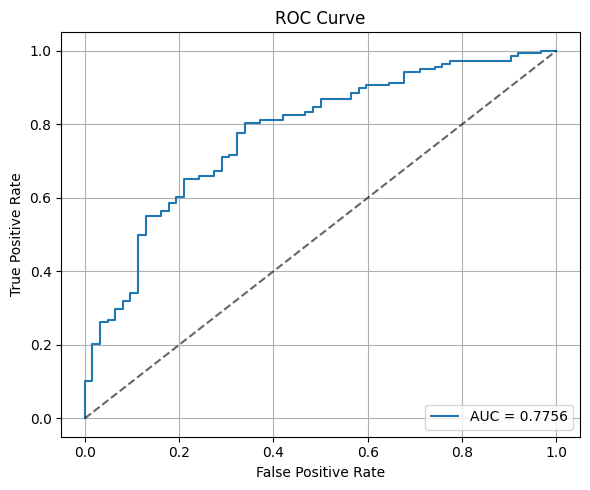

In [164]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_classes = (predictions > 0.5).float()

    # Accuracy and classification report
    accuracy = accuracy_score(y_test_tensor, predicted_classes)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(classification_report(y_test_tensor, predicted_classes, digits=3))

    # ROC AUC
    y_true = y_test_tensor.numpy()
    y_score = predictions.numpy()
    auc_score = roc_auc_score(y_true, y_score)
    print(f"ROC AUC Score: {auc_score:.4f}")

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [171]:
# Choose one row from your data
x_cat = torch.tensor(df[categorical_features].iloc[[1]].values, dtype=torch.long)
x_cont = torch.tensor(df[continuous_features].iloc[[1]].values, dtype=torch.float32)
x_input = torch.cat([x_cat, x_cont], dim=1)

with torch.no_grad():
    prob = model(x_input).item()

print(f"Predicted probability of good credit: {prob:.3f}")


Predicted probability of good credit: 0.725


In [172]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_feature_effect(
    model,
    feature_name,
    df_scaled,
    df_original,
    categorical_features,
    continuous_features,
    scaler=None,
    base_row_index=0,
    num_points=100,
    bins=30
):
    model.eval()

    num_cat = len(categorical_features)

    is_categorical = feature_name in categorical_features
    is_continuous = feature_name in continuous_features

    if not (is_categorical or is_continuous):
        raise ValueError(f"Feature '{feature_name}' not found in categorical or continuous feature lists.")

    # Get base row to modify
    base_row = df_scaled[categorical_features + continuous_features].iloc[base_row_index].copy()
    dummy_rows = []

    if is_categorical:
        idx = categorical_features.index(feature_name)
        unique_vals = sorted(df_scaled[feature_name].unique())

        for val in unique_vals:
            modified = base_row.copy()
            modified[idx] = val
            dummy_rows.append(modified.values)

        x_vals = unique_vals
        hist_vals = df_original[feature_name].values

    else:
        idx = continuous_features.index(feature_name)
        full_idx = num_cat + idx

        scaled_min = df_scaled[continuous_features][feature_name].min()
        scaled_max = df_scaled[continuous_features][feature_name].max()
        scaled_vals = np.linspace(scaled_min, scaled_max, num_points)

        for val in scaled_vals:
            modified = base_row.copy()
            modified[full_idx] = val
            dummy_rows.append(modified.values)

        # Unscale for plotting
        mean = scaler.mean_[idx]
        std = scaler.scale_[idx]
        x_vals = scaled_vals * std + mean
        hist_vals = df_original[feature_name].values

    dummy_array = np.vstack(dummy_rows)
    X_cat = torch.tensor(dummy_array[:, :num_cat], dtype=torch.long)
    X_cont = torch.tensor(dummy_array[:, num_cat:], dtype=torch.float32)
    X_input = torch.cat([X_cat, X_cont], dim=1)

    with torch.no_grad():
        y_pred = model(X_input).squeeze().cpu().numpy()

    # Plot
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax2 = ax1.twinx()

    if is_categorical:
        ax1.plot(x_vals, y_pred, 'o-', color='blue')
        ax2.hist(hist_vals, bins=len(x_vals), alpha=0.3, color='gray', edgecolor='black', align='left')
        ax1.set_xlabel(f"{feature_name} (Category Index)")
    else:
        ax1.plot(x_vals, y_pred, color='blue')
        ax2.hist(hist_vals, bins=bins, alpha=0.3, color='gray', edgecolor='black')
        ax1.set_xlabel(f"{feature_name} (Original Scale)")

    ax1.set_ylabel("Predicted Probability", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.set_ylabel("Feature Frequency", color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    plt.title(f"Effect of {feature_name} on Predicted Probability")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


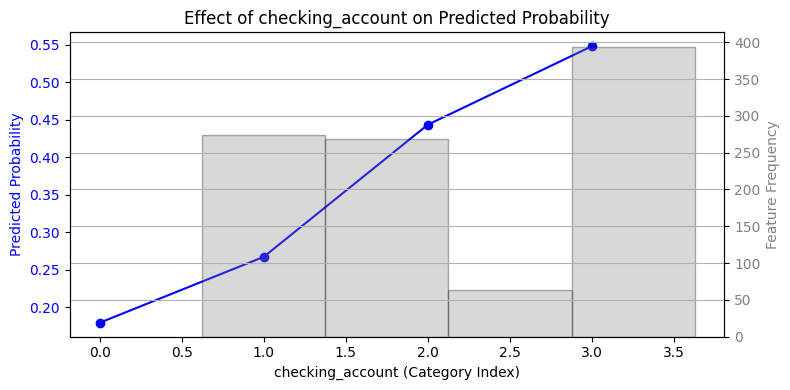

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


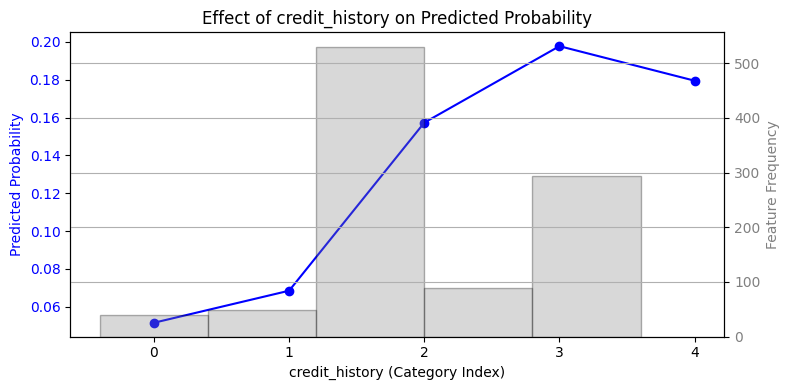

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


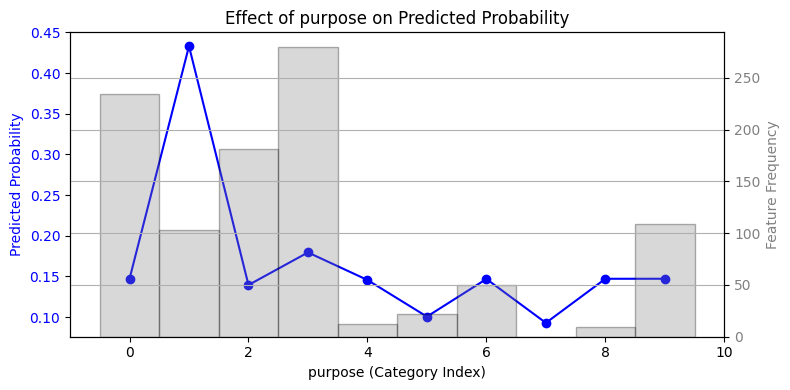

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


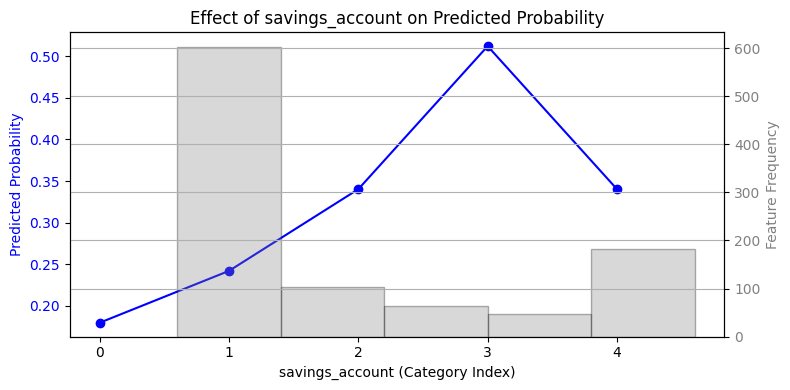

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


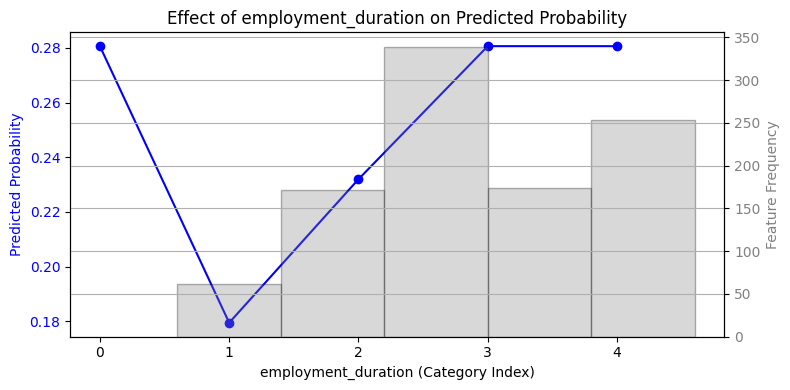

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


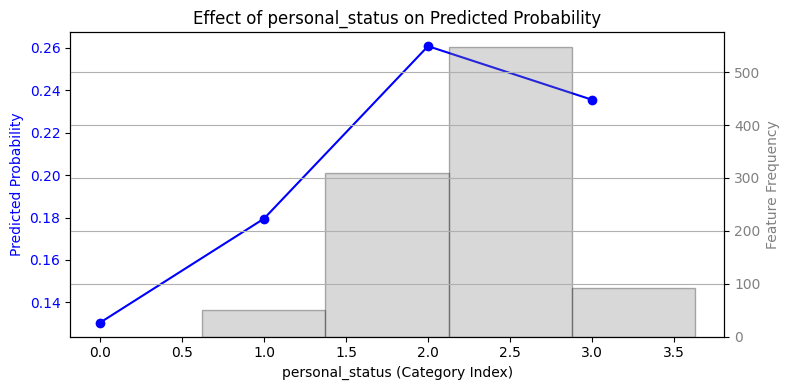

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


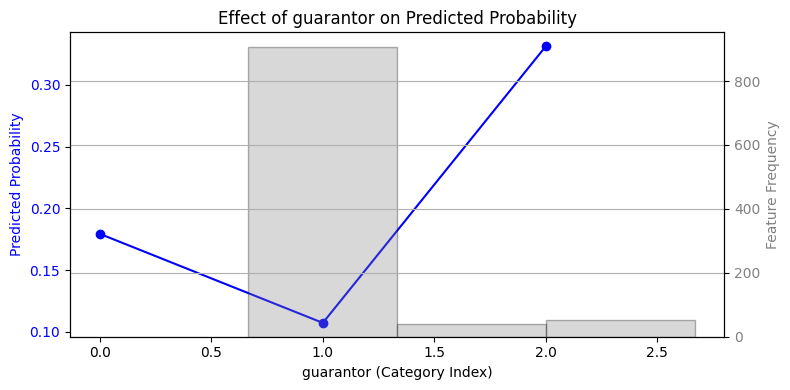

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


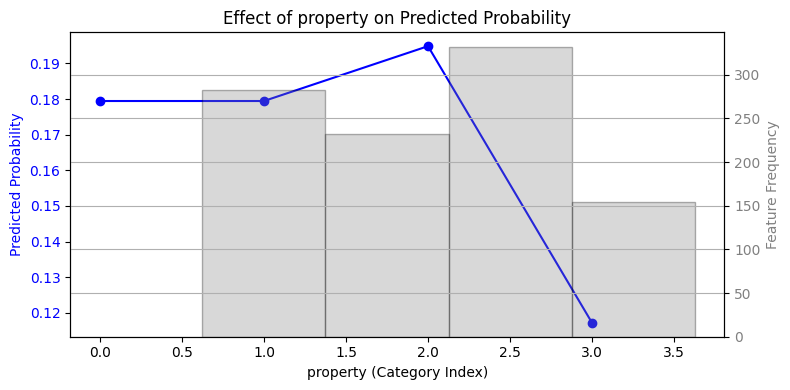

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


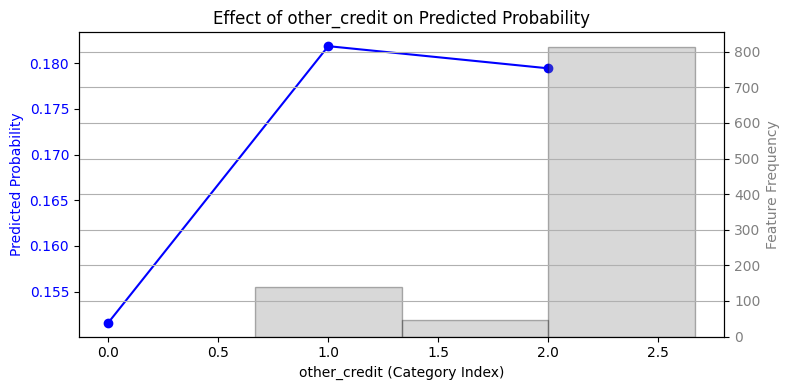

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


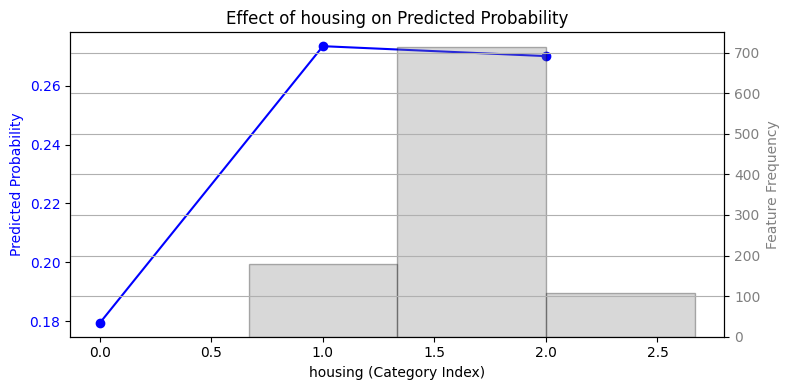

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


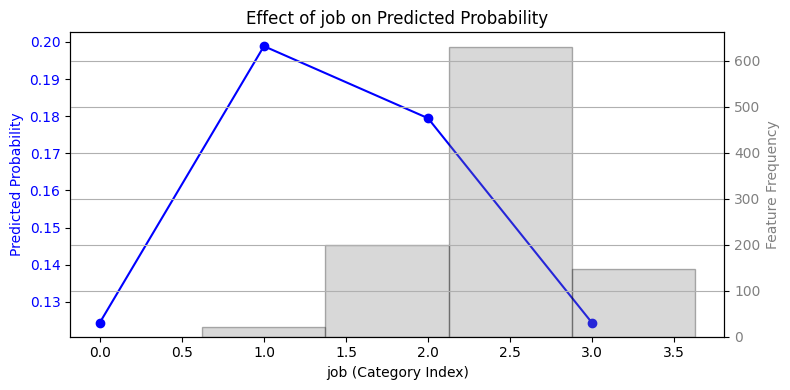

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


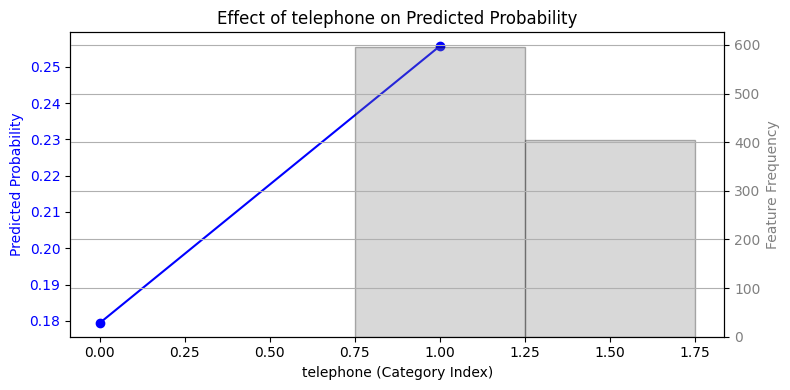

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


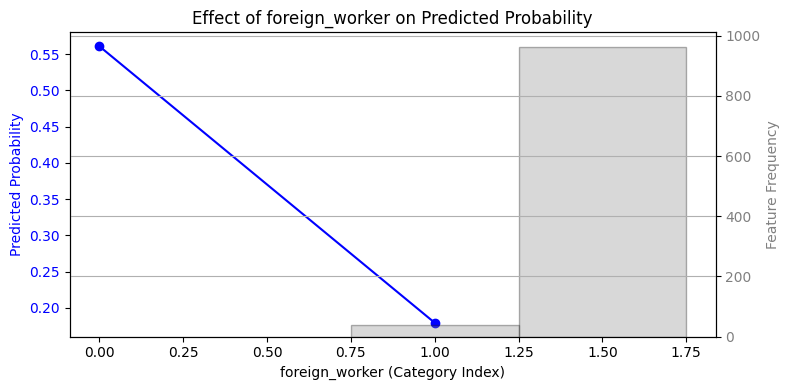

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


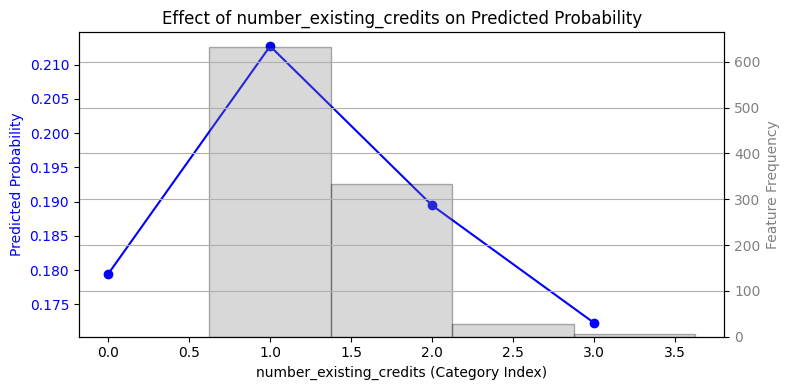

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


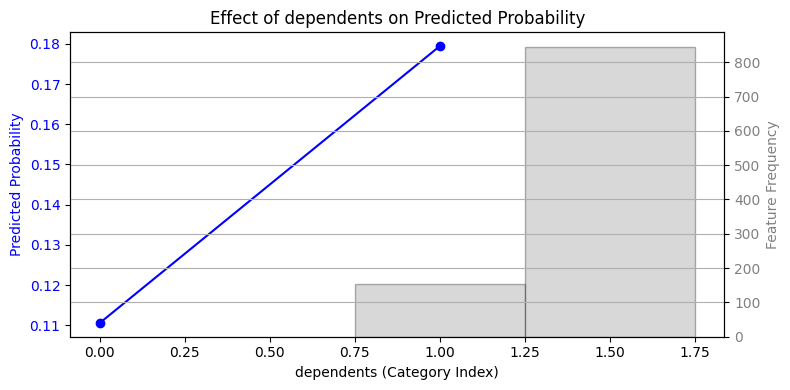

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


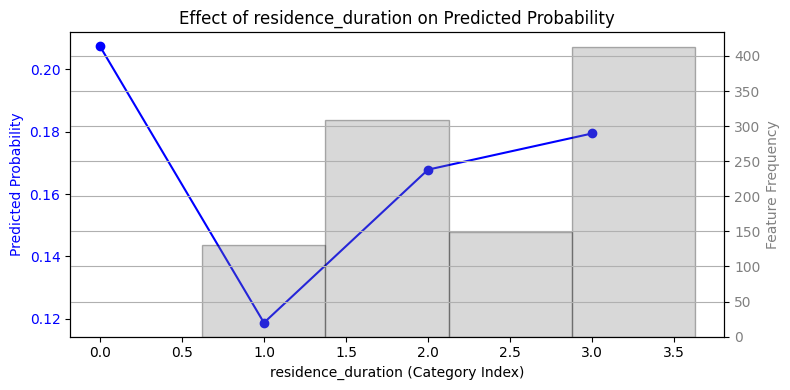

<ipython-input-172-30aac29b8089>:38: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[idx] = val


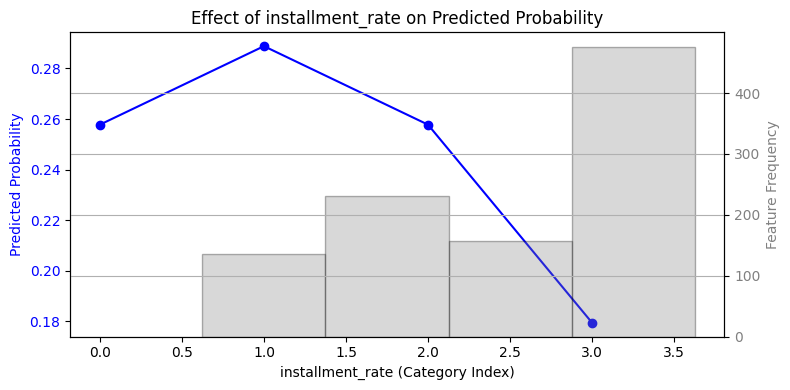

<ipython-input-172-30aac29b8089>:54: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[full_idx] = val


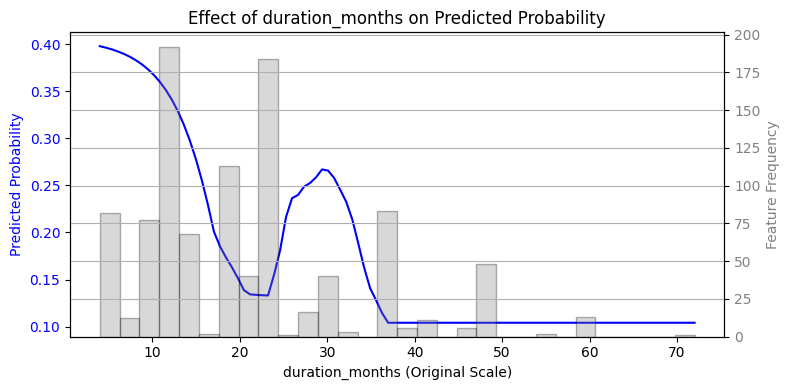

<ipython-input-172-30aac29b8089>:54: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[full_idx] = val


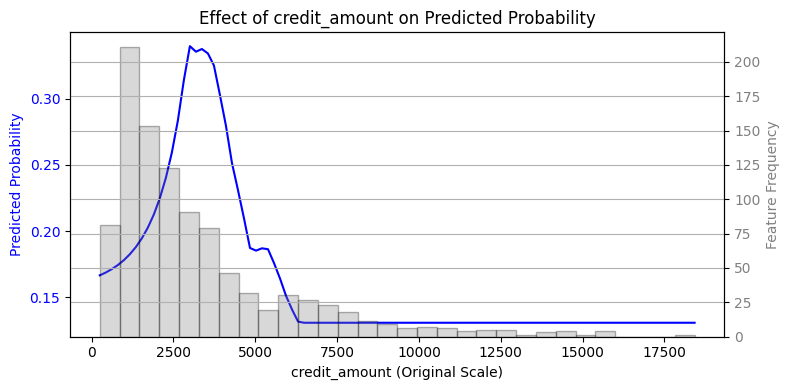

<ipython-input-172-30aac29b8089>:54: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  modified[full_idx] = val


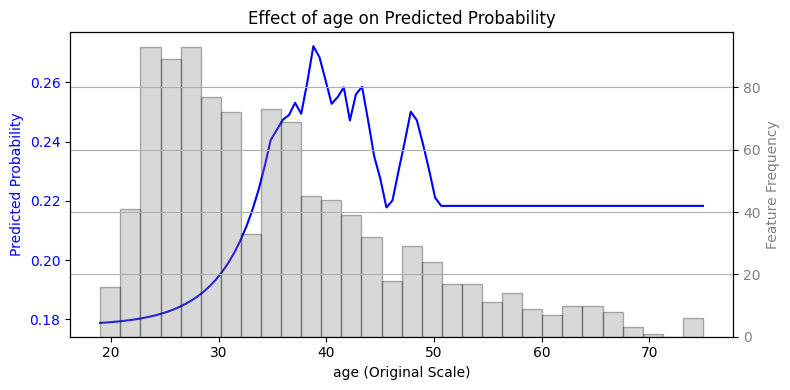

In [173]:
for feat in categorical_features + continuous_features:
    plot_feature_effect(
        model=model,
        feature_name=feat,
        df_scaled=df,
        df_original=df_original,
        categorical_features=categorical_features,
        continuous_features=continuous_features,
        scaler=scaler
    )


In [174]:
# Assume your model is already trained and defined as `model`
# Also assumes df, categorical_features, continuous_features are already defined

# 1️⃣ Determine input dimensions
num_categorical = len(categorical_features)
num_continuous = len(continuous_features)

# Get number of unique values for each categorical feature (for embedding indices)
cat_dims = [df[feature].nunique() for feature in categorical_features]

# 2️⃣ Generate valid dummy categorical input (integers in range for embeddings)
fake_cats = [np.random.randint(0, dim, size=(1,)) for dim in cat_dims]
fake_cats_tensor = torch.tensor(np.hstack(fake_cats), dtype=torch.long).unsqueeze(0)  # shape: (1, num_categorical)

# 3️⃣ Generate dummy continuous input (random floats)
fake_conts_tensor = torch.randn(1, num_continuous)  # shape: (1, num_continuous)

# 4️⃣ Combine categorical and continuous parts into one tensor
dummy_input = torch.cat([fake_cats_tensor.float(), fake_conts_tensor], dim=1)  # shape: (1, total_features)

# 5️⃣ Export to ONNX
torch.onnx.export(
    model,                      # Your trained model
    dummy_input,                # Dummy input
    "nam_model.onnx",           # Output ONNX filename
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    opset_version=11
)

print("✅ NAM model successfully exported to ONNX format: nam_model.onnx")


✅ NAM model successfully exported to ONNX format: nam_model.onnx


# upload onnx file to netron.app to visualize the network
# file should be available at content/nam_model.onnx

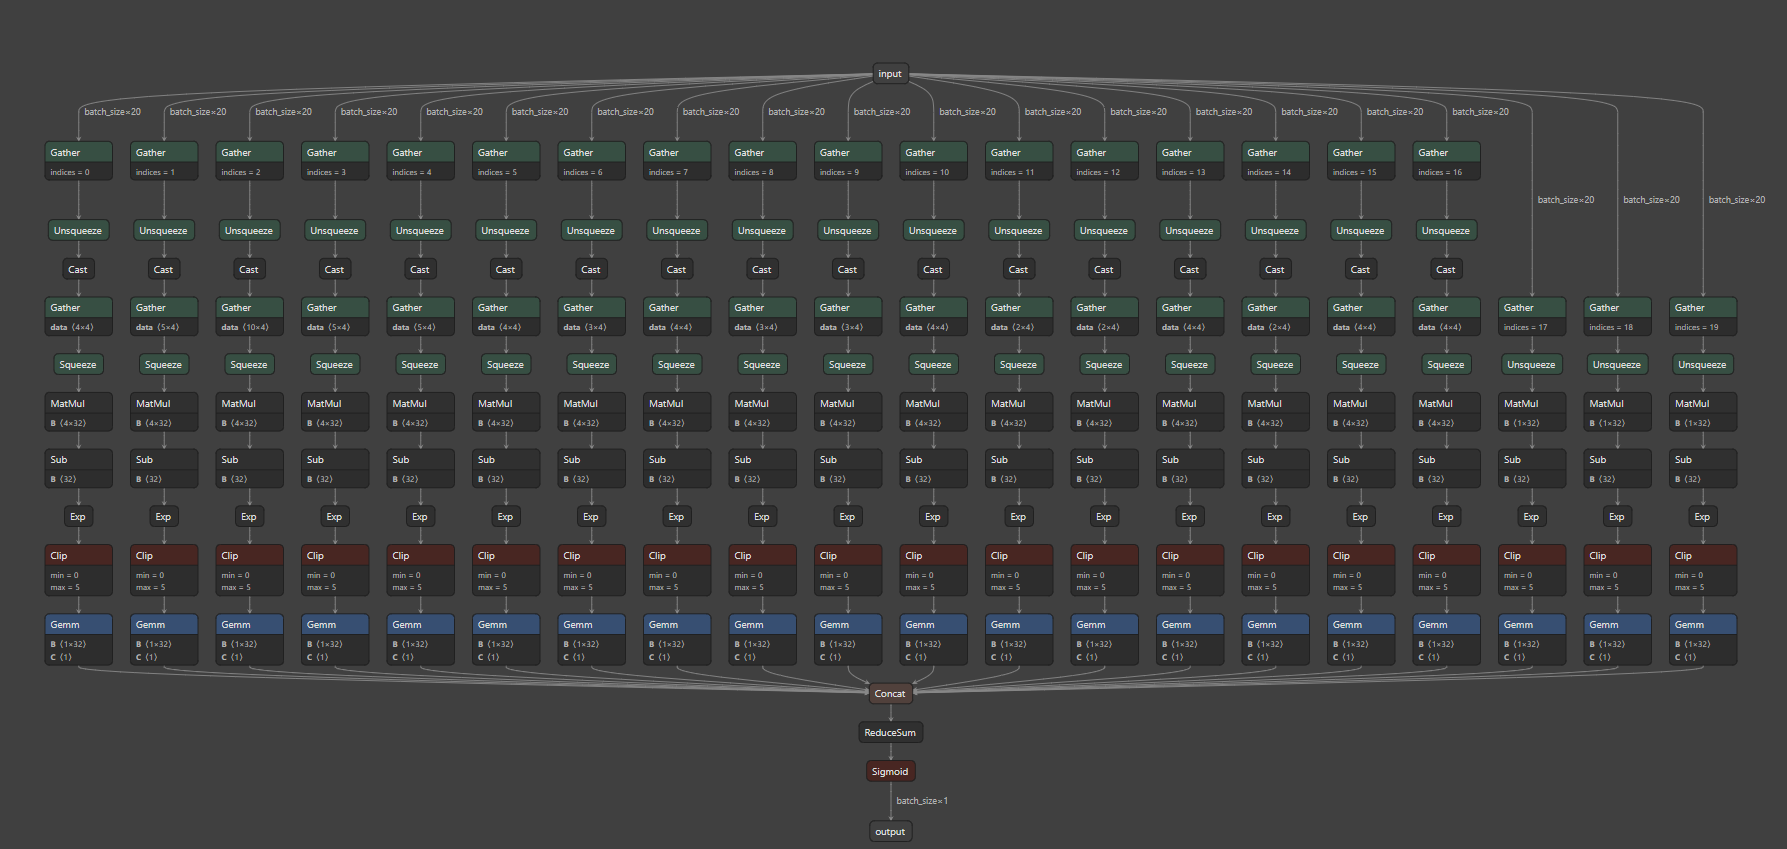

### We could try further to:
- 🔄 Implement **multitask outputs** (as explored in the NAM paper)?
- 🧪 Add **dropout**, **weight decay**, or other **regularization strategies**?
- 🛠️ Run a **hyperparameter search** to optimize architecture and training?
- ⚖️ Extend the **loss function to include responsible ML objectives**, such as:
  - **Fairness** (e.g., equalized odds or demographic parity penalties)
  - **Robustness** to adversarial or distributional shifts
  - **Sparsity or monotonicity constraints** for trustworthiness
- 🤝 Combine NAMs with **other interpretable modules** (e.g., attention, rule-based logic)
- 🔍 Investigate and address **multicollinearity among features** to improve the interpretability of individual feature plots and ensure stable, independent feature effects
